In [6]:
# Updated LSTM sequence model script — robust label handling
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import joblib

# ---------------- USER CONFIG (edit as needed) ----------------
INPUT_CSV = r"C:\Users\saiku\Desktop\NSS_TAG\sim2\dataset2\mobility_final.csv"
OUT_DIR = "./lstm_run"
os.makedirs(OUT_DIR, exist_ok=True)

SEQ_LEN = 10
STEP = 1
MAX_VEHICLES = None            # None => use all
MAX_SEQS_PER_VEHICLE = 50
TEST_SIZE = 0.15
VAL_SIZE = 0.15
BATCH_SIZE = 256
EPOCHS = 20
RANDOM_STATE = 42
USE_CLASS_WEIGHTS = True
SAVE_SEQ_TO_DISK = True

LEAKS = ["overlap_flag", "speed_violation", "sybil_cluster_score", 
         "witness_score", "witness_count", "neighbor_reliability"]
FEATURES_TO_DROP = []  # add any other columns to drop from features
# -------------------------------------------------------------

print("Loading CSV:", INPUT_CSV)
df = pd.read_csv(INPUT_CSV)
print("Rows:", len(df), "Columns:", df.columns.tolist())

# --- basic checks ---
if "vehicle_id" not in df.columns:
    raise KeyError("Input CSV must contain 'vehicle_id' column.")
if "label" not in df.columns:
    raise KeyError("Input CSV must contain 'label' column.")

# Ensure vehicle_id is string for safe grouping
df["vehicle_id"] = df["vehicle_id"].astype(str)

# Normalize/encode label -> numeric 0/1
if df["label"].dtype == object or not np.issubdtype(df["label"].dtype, np.number):
    unique_labels = sorted(df["label"].dropna().unique(), key=lambda x: str(x).lower())
    print("Found non-numeric labels. Unique values:", unique_labels)
    # common mapping heuristics
    mapping = {}
    low = [str(u).lower() for u in unique_labels]
    if "honest" in low and "sybil" in low:
        mapping = {u: (0 if str(u).lower() == "honest" else 1) for u in unique_labels}
    elif "benign" in low and "malicious" in low:
        mapping = {u: (0 if str(u).lower() in ("benign","honest") else 1) for u in unique_labels}
    else:
        # fallback: map first unique -> 0, others -> 1 (preserve order)
        mapping = {unique_labels[0]: 0}
        for u in unique_labels[1:]:
            mapping[u] = 1
    print("Label mapping used:", mapping)
    df["label"] = df["label"].map(mapping).astype(int)
else:
    # numeric already — ensure integer type 0/1
    df["label"] = pd.to_numeric(df["label"], errors="coerce").fillna(0).astype(int)

# Convert time to datetime if present
if "time" in df.columns:
    df["time"] = pd.to_datetime(df["time"], errors="coerce")
    df = df.sort_values(["vehicle_id", "time"]).reset_index(drop=True)
else:
    df = df.sort_values(["vehicle_id"]).reset_index(drop=True)
    print("No 'time' column — sequences ordered by row order per vehicle.")

# Drop leaking features from features (but keep vehicle_id & time for grouping)
leaks_present = [c for c in LEAKS if c in df.columns]
if leaks_present:
    print("Dropping leak columns from feature set:", leaks_present)
    df = df.drop(columns=leaks_present)

if FEATURES_TO_DROP:
    print("Dropping user-specified feature columns:", FEATURES_TO_DROP)
    df = df.drop(columns=[c for c in FEATURES_TO_DROP if c in df.columns], errors="ignore")

# Build feature list (exclude vehicle_id, time, label)
excluded = {"vehicle_id", "time", "label"}
feature_cols = [c for c in df.columns if c not in excluded]
print("Feature columns (n={}): {}".format(len(feature_cols), feature_cols[:30]))

# Ensure numeric features
df[feature_cols] = df[feature_cols].apply(pd.to_numeric, errors="coerce").fillna(0.0)

# Optionally limit vehicles
vehicle_ids = df["vehicle_id"].unique()
print("Distinct vehicles:", len(vehicle_ids))
if MAX_VEHICLES is not None and len(vehicle_ids) > MAX_VEHICLES:
    vehicle_ids = vehicle_ids[:MAX_VEHICLES]
    df = df[df["vehicle_id"].isin(vehicle_ids)].copy()
    print("Limited to", len(vehicle_ids), "vehicles -> rows:", len(df))

# Scale features globally (fit scaler)
scaler = StandardScaler()
df[feature_cols] = scaler.fit_transform(df[feature_cols])
joblib.dump(scaler, os.path.join(OUT_DIR, "scaler_lstm.pkl"))
print("Scaler saved to:", os.path.join(OUT_DIR, "scaler_lstm.pkl"))

# Sequence generator (robust)
def generate_sequences_for_vehicle(vdf, seq_len=SEQ_LEN, step=STEP, max_seqs=None):
    seqs = []
    vals = vdf[feature_cols].values
    labs = vdf["label"].values
    n = len(vdf)
    if n < seq_len:
        return seqs
    starts = range(0, n - seq_len + 1, step)
    count = 0
    for s in starts:
        if max_seqs is not None and count >= max_seqs:
            break
        seq = vals[s:s+seq_len]
        # labs[s:s+seq_len] is numeric 0/1 now; take max to label sequence
        lab = int(np.max(labs[s:s+seq_len]))
        seqs.append((seq, lab))
        count += 1
    return seqs

# Generate sequences
print("Generating sequences per vehicle (this may take time)...")
seqs = []
labels = []
seq_to_vid = []
processed = 0
for vid in vehicle_ids:
    vdf = df[df["vehicle_id"] == vid]
    s = generate_sequences_for_vehicle(vdf, seq_len=SEQ_LEN, step=STEP, max_seqs=MAX_SEQS_PER_VEHICLE)
    if s:
        arrs, labs = zip(*s)
        seqs.extend(arrs)
        labels.extend(labs)
        seq_to_vid.extend([vid]*len(arrs))
    processed += 1
    if processed % 200 == 0:
        print("Processed", processed, "vehicles; sequences so far:", len(seqs))

if len(seqs) == 0:
    raise RuntimeError("No sequences generated — try lowering SEQ_LEN or increasing MAX_VEHICLES / MAX_SEQS_PER_VEHICLE.")

X = np.stack(seqs).astype(np.float32)
y = np.array(labels, dtype=np.int32)
seq_to_vid = np.array(seq_to_vid)
print("Total sequences:", X.shape, "Label counts:", np.bincount(y))

# Save sequences if requested
if SAVE_SEQ_TO_DISK:
    np.save(os.path.join(OUT_DIR, f"X_seq_len{SEQ_LEN}.npy"), X)
    np.save(os.path.join(OUT_DIR, f"y_seq_len{SEQ_LEN}.npy"), y)
    np.save(os.path.join(OUT_DIR, f"seq_to_vid_seq_len{SEQ_LEN}.npy"), seq_to_vid)
    print("Saved sequences and mapping to:", OUT_DIR)

# Train/val/test split (sequence-level)
X_trainval, X_test, y_trainval, y_test, idx_trainval, idx_test = train_test_split(
    X, y, np.arange(len(y)), test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)
X_train, X_val, y_train, y_val, idx_train, idx_val = train_test_split(
    X_trainval, y_trainval, idx_trainval, test_size=VAL_SIZE, random_state=RANDOM_STATE, stratify=y_trainval)

print("Train/val/test shapes:", X_train.shape, X_val.shape, X_test.shape)
print("Train balance:", np.bincount(y_train), "Val:", np.bincount(y_val), "Test:", np.bincount(y_test))

# Class weights if enabled
if USE_CLASS_WEIGHTS:
    unique, counts = np.unique(y_train, return_counts=True)
    class_weight = {int(u): (len(y_train) / (len(unique) * cnt)) for u, cnt in zip(unique, counts)}
    print("Using class_weight:", class_weight)
else:
    class_weight = None

# Build model
n_features = X.shape[2]
print("Building LSTM model: seq_len", SEQ_LEN, "n_features", n_features)
model = models.Sequential([
    layers.Input(shape=(SEQ_LEN, n_features)),
    layers.Masking(mask_value=0.0),
    layers.Bidirectional(layers.LSTM(128, return_sequences=True)),
    layers.Dropout(0.3),
    layers.Bidirectional(layers.LSTM(64)),
    layers.Dropout(0.25),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss="binary_crossentropy",
              metrics=[tf.keras.metrics.AUC(name="auc")])
model.summary()

# Callbacks
cb = [
    callbacks.ModelCheckpoint(os.path.join(OUT_DIR, "lstm_best.h5"), save_best_only=True, monitor="val_auc", mode="max"),
    callbacks.EarlyStopping(monitor="val_auc", patience=6, mode="max", restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3)
]

# Train
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    class_weight=class_weight,
    callbacks=cb,
    verbose=1
)

# Save model & history
model.save(os.path.join(OUT_DIR, "lstm_final.h5"))
joblib.dump(history.history, os.path.join(OUT_DIR, "lstm_history.pkl"))
print("Model and history saved to:", OUT_DIR)

# Evaluate on test set (sequence-level)
y_proba = model.predict(X_test, batch_size=BATCH_SIZE).ravel()
y_pred = (y_proba >= 0.5).astype(int)
print("Sequence-level classification report:")
print(classification_report(y_test, y_pred, digits=4))
print("ROC-AUC (seq):", roc_auc_score(y_test, y_proba))
print("Average Precision (seq):", average_precision_score(y_test, y_proba))

# Map sequence preds back to vehicles (per-vehicle detection)
test_seq_indices = idx_test
test_seq_vids = seq_to_vid[test_seq_indices]
df_seq_preds = pd.DataFrame({
    "seq_idx": test_seq_indices,
    "vehicle_id": test_seq_vids,
    "y_true_seq": y_test,
    "y_pred_seq": y_pred,
    "y_prob_seq": y_proba
})
per_vehicle = df_seq_preds.groupby("vehicle_id").agg({
    "y_true_seq": "max",
    "y_pred_seq": "max",
    "y_prob_seq": "max",
}).rename(columns={"y_true_seq":"true_vehicle_sybil","y_pred_seq":"pred_vehicle_sybil","y_prob_seq":"pred_vehicle_prob"})

print("\nPer-vehicle counts (test):")
print(per_vehicle["true_vehicle_sybil"].value_counts())
print(per_vehicle["pred_vehicle_sybil"].value_counts())

y_true_vehicle = per_vehicle["true_vehicle_sybil"].values
y_pred_vehicle = per_vehicle["pred_vehicle_sybil"].values
print("\nPer-vehicle classification report:")
print(classification_report(y_true_vehicle, y_pred_vehicle, digits=4))
print("Per-vehicle ROC-AUC:", roc_auc_score(y_true_vehicle, per_vehicle["pred_vehicle_prob"].values))
print("Per-vehicle Average Precision:", average_precision_score(y_true_vehicle, per_vehicle["pred_vehicle_prob"].values))

print("Done. Outputs saved in:", OUT_DIR)


Loading CSV: C:\Users\saiku\Desktop\NSS_TAG\sim2\dataset2\mobility_final.csv
Rows: 2978674 Columns: ['time', 'vehicle_id', 'x', 'y', 'reported_speed_mps', 'heading_deg', 'displacement_m', 'implied_speed_mps', 'acceleration', 'velocity_consistency_abs_diff', 'neighbor_diversity_window', 'witness_count', 'witness_score', 'rssi_dbm_mean', 'overlap_flag', 'speed_violation', 'sybil_cluster_score', 'label']
Found non-numeric labels. Unique values: ['honest', 'sybil']
Label mapping used: {'honest': 0, 'sybil': 1}
Dropping leak columns from feature set: ['overlap_flag', 'speed_violation', 'sybil_cluster_score', 'witness_score', 'witness_count']
Feature columns (n=10): ['x', 'y', 'reported_speed_mps', 'heading_deg', 'displacement_m', 'implied_speed_mps', 'acceleration', 'velocity_consistency_abs_diff', 'neighbor_diversity_window', 'rssi_dbm_mean']
Distinct vehicles: 3800
Scaler saved to: ./lstm_run\scaler_lstm.pkl
Generating sequences per vehicle (this may take time)...
Processed 200 vehicles; 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ masking (Masking)                    │ (None, 10, 10)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 10, 256)             │         142,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 315,009 (1.20 MB)

 Trainable params: 315,009 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
530/530 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - auc: 0.9405 - loss: 0.2949

530/530 ━━━━━━━━━━━━━━━━━━━━ 154s 248ms/step - auc: 0.9406 - loss: 0.2947 - val_auc: 0.9948 - val_loss: 0.0653 - learning_rate: 0.0010
Epoch 2/20
530/530 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - auc: 0.9831 - loss: 0.0849

530/530 ━━━━━━━━━━━━━━━━━━━━ 122s 230ms/step - auc: 0.9832 - loss: 0.0849 - val_auc: 0.9953 - val_loss: 0.0710 - learning_rate: 0.0010
Epoch 3/20
530/530 ━━━━━━━━━━━━━━━━━━━━ 126s 237ms/step - auc: 0.9906 - loss: 0.0884 - val_auc: 0.9911 - val_loss: 0.2022 - learning_rate: 0.0010
Epoch 4/20
530/530 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - auc: 0.9885 - loss: 0.1025

530/530 ━━━━━━━━━━━━━━━━━━━━ 120s 226ms/step - auc: 0.9885 - loss: 0.1025 - val_auc: 0.9968 - val_loss: 0.0820 - learning_rate: 0.0010
Epoch 5/20
530/530 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - auc: 0.9884 - loss: 0.0840

530/530 ━━━━━━━━━━━━━━━━━━━━ 119s 225ms/step - auc: 0.9884 - loss: 0.0839 - val_auc: 0.9983 - val_loss: 0.0307 - learning_rate: 5.0000e-04
Epoch 6/20
530/530 ━━━━━━━━━━━━━━━━━━━━ 122s 230ms/step - auc: 0.9956 - loss: 0.0281 - val_auc: 0.9922 - val_loss: 0.1374 - learning_rate: 5.0000e-04
Epoch 7/20
530/530 ━━━━━━━━━━━━━━━━━━━━ 120s 226ms/step - auc: 0.9921 - loss: 0.0463 - val_auc: 0.9970 - val_loss: 0.0567 - learning_rate: 5.0000e-04
Epoch 8/20
530/530 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - auc: 0.9951 - loss: 0.0417

530/530 ━━━━━━━━━━━━━━━━━━━━ 143s 227ms/step - auc: 0.9951 - loss: 0.0417 - val_auc: 0.9983 - val_loss: 0.0359 - learning_rate: 5.0000e-04
Epoch 9/20
530/530 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - auc: 0.9938 - loss: 0.0270

530/530 ━━━━━━━━━━━━━━━━━━━━ 128s 241ms/step - auc: 0.9938 - loss: 0.0270 - val_auc: 0.9988 - val_loss: 0.0246 - learning_rate: 2.5000e-04
Epoch 10/20
530/530 ━━━━━━━━━━━━━━━━━━━━ 127s 239ms/step - auc: 0.9981 - loss: 0.0182 - val_auc: 0.9985 - val_loss: 0.0365 - learning_rate: 2.5000e-04
Epoch 11/20
530/530 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - auc: 0.9944 - loss: 0.0190

530/530 ━━━━━━━━━━━━━━━━━━━━ 126s 238ms/step - auc: 0.9944 - loss: 0.0190 - val_auc: 0.9990 - val_loss: 0.0222 - learning_rate: 2.5000e-04
Epoch 12/20
530/530 ━━━━━━━━━━━━━━━━━━━━ 119s 224ms/step - auc: 0.9944 - loss: 0.0161 - val_auc: 0.9989 - val_loss: 0.0193 - learning_rate: 2.5000e-04
Epoch 13/20
530/530 ━━━━━━━━━━━━━━━━━━━━ 114s 215ms/step - auc: 0.9965 - loss: 0.0156 - val_auc: 0.9987 - val_loss: 0.0198 - learning_rate: 2.5000e-04
Epoch 14/20
530/530 ━━━━━━━━━━━━━━━━━━━━ 111s 210ms/step - auc: 0.9965 - loss: 0.0144 - val_auc: 0.9960 - val_loss: 0.0795 - learning_rate: 2.5000e-04
Epoch 15/20
530/530 ━━━━━━━━━━━━━━━━━━━━ 110s 208ms/step - auc: 0.9971 - loss: 0.0283 - val_auc: 0.9984 - val_loss: 0.0269 - learning_rate: 2.5000e-04
Epoch 16/20
530/530 ━━━━━━━━━━━━━━━━━━━━ 110s 208ms/step - auc: 0.9943 - loss: 0.0168 - val_auc: 0.9987 - val_loss: 0.0207 - learning_rate: 1.2500e-04
Epoch 17/20
530/530 ━━━━━━━━━━━━━━━━━━━━ 111s 210ms/step - auc: 0.9984 - loss: 0.0148 - val_auc: 0.9988 - 

Model and history saved to: ./lstm_run
110/110 ━━━━━━━━━━━━━━━━━━━━ 13s 98ms/step
Sequence-level classification report:
              precision    recall  f1-score   support

           0     1.0000    0.9942    0.9971     28091
           1     0.2407    1.0000    0.3881        52

    accuracy                         0.9942     28143
   macro avg     0.6204    0.9971    0.6926     28143
weighted avg     0.9986    0.9942    0.9959     28143

ROC-AUC (seq): 0.9988225081671381
Average Precision (seq): 0.4949899077440417

Per-vehicle counts (test):
true_vehicle_sybil
0    3780
1       7
Name: count, dtype: int64
pred_vehicle_sybil
0    3726
1      61
Name: count, dtype: int64

Per-vehicle classification report:
              precision    recall  f1-score   support

           0     1.0000    0.9857    0.9928      3780
           1     0.1148    1.0000    0.2059         7

    accuracy                         0.9857      3787
   macro avg     0.5574    0.9929    0.5993      3787
weighted 

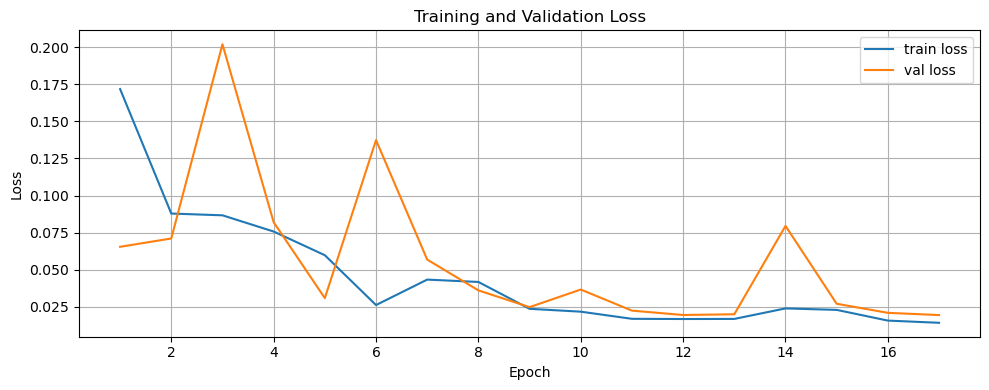

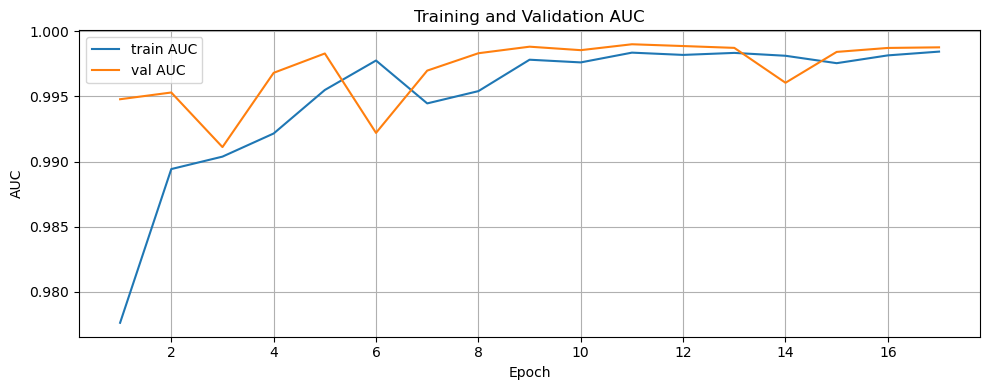

Loaded sequences: (187620, 10, 10) labels: [187270    350]
Split shapes -> train: (135555, 10, 10) val: (23922, 10, 10) test: (28143, 10, 10)


Loaded model: ./lstm_run\lstm_final.h5
110/110 ━━━━━━━━━━━━━━━━━━━━ 28s 195ms/step


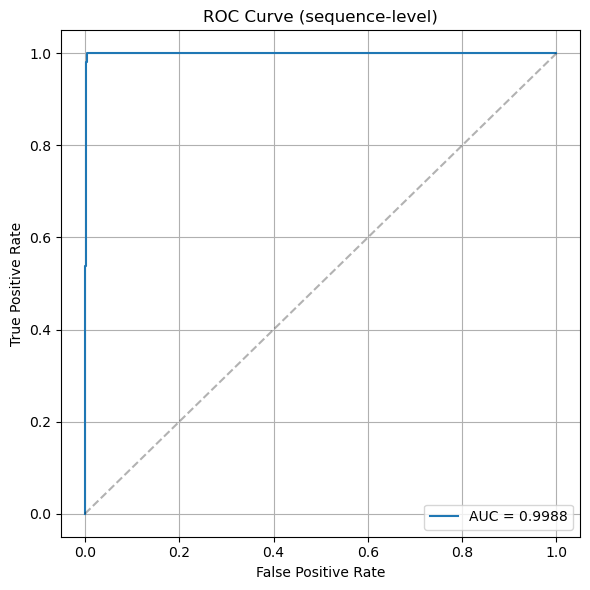

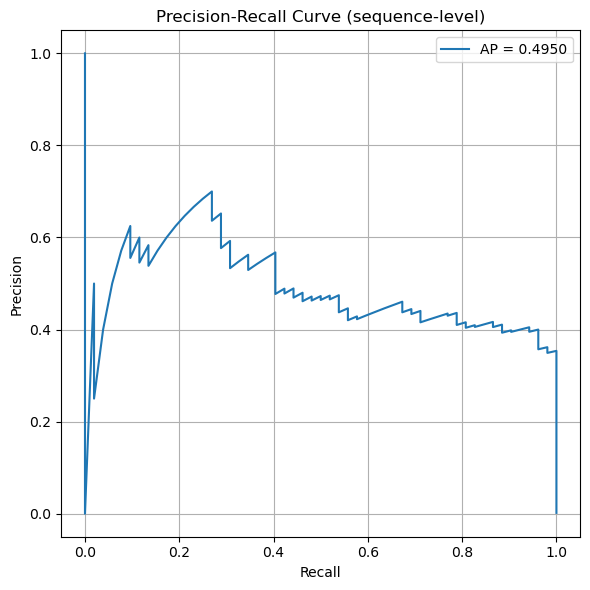

Sequence-level classification report:
              precision    recall  f1-score   support

           0     1.0000    0.9942    0.9971     28091
           1     0.2407    1.0000    0.3881        52

    accuracy                         0.9942     28143
   macro avg     0.6204    0.9971    0.6926     28143
weighted avg     0.9986    0.9942    0.9959     28143



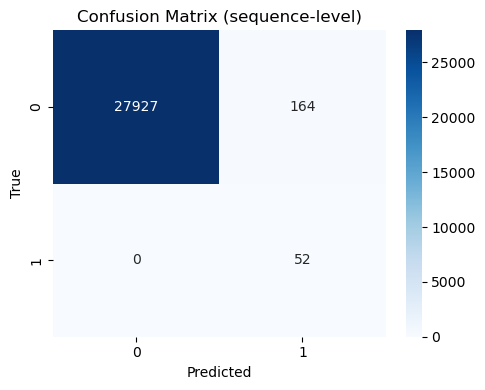


Per-vehicle counts (test set):
true_vehicle_sybil
0    3780
1       7
Name: count, dtype: int64
pred_vehicle_sybil
0    3726
1      61
Name: count, dtype: int64


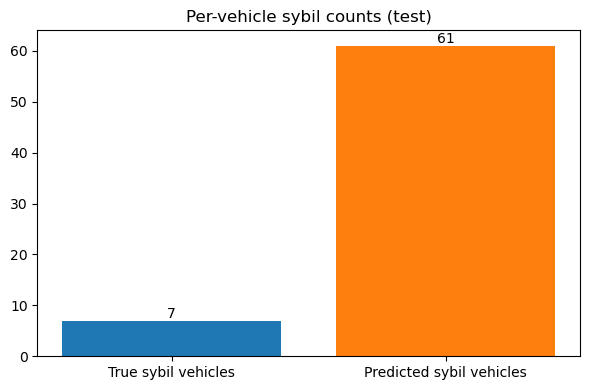


Per-vehicle classification report:
              precision    recall  f1-score   support

           0     1.0000    0.9857    0.9928      3780
           1     0.1148    1.0000    0.2059         7

    accuracy                         0.9857      3787
   macro avg     0.5574    0.9929    0.5993      3787
weighted avg     0.9984    0.9857    0.9914      3787

Per-vehicle ROC-AUC: 0.9992441421012849
Per-vehicle Average Precision: 0.5743506493506494

All plots written to: ./lstm_run\plots


In [6]:
# Plotting & evaluation script for LSTM outputs (single Jupyter cell)
import os
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    roc_curve, auc, precision_recall_curve, average_precision_score,
    classification_report, confusion_matrix
)
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model

# ---------- CONFIG (match what you used for LSTM run) ----------
OUT_DIR = "./lstm_run"         # where history, model, sequences were saved
SEQ_LEN = 10
TEST_SIZE = 0.15
VAL_SIZE = 0.15
RANDOM_STATE = 42
PLOTS_DIR = os.path.join(OUT_DIR, "plots")
os.makedirs(PLOTS_DIR, exist_ok=True)
# ---------------------------------------------------------------

# ---------- Load history ----------
history_path = os.path.join(OUT_DIR, "lstm_history.pkl")
if not os.path.exists(history_path):
    raise FileNotFoundError(f"History not found at {history_path}. Make sure your LSTM script saved it.")
history = joblib.load(history_path)  # dict: keys like 'loss','val_loss','auc','val_auc'

# ---------- Plot training curves ----------
epochs = range(1, len(history.get("loss", [])) + 1)

plt.figure(figsize=(10,4))
plt.plot(epochs, history.get("loss", []), label="train loss")
plt.plot(epochs, history.get("val_loss", []), label="val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, "loss_curve.png"))
plt.show()

plt.figure(figsize=(10,4))
plt.plot(epochs, history.get("auc", []), label="train AUC")
plt.plot(epochs, history.get("val_auc", []), label="val AUC")
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.title("Training and Validation AUC")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, "auc_curve.png"))
plt.show()

# ---------- Load sequences and labels ----------
X_path = os.path.join(OUT_DIR, f"X_seq_len{SEQ_LEN}.npy")
y_path = os.path.join(OUT_DIR, f"y_seq_len{SEQ_LEN}.npy")
seq_to_vid_path = os.path.join(OUT_DIR, f"seq_to_vid_seq_len{SEQ_LEN}.npy")
for p in (X_path, y_path, seq_to_vid_path):
    if not os.path.exists(p):
        raise FileNotFoundError(f"Required file not found: {p}. Ensure sequences were saved in the LSTM run.")

X_all = np.load(X_path)
y_all = np.load(y_path)
seq_to_vid = np.load(seq_to_vid_path)

print("Loaded sequences:", X_all.shape, "labels:", np.bincount(y_all))
# Recreate the same train/val/test split as used in LSTM script
X_trainval, X_test, y_trainval, y_test, idx_trainval, idx_test = train_test_split(
    X_all, y_all, np.arange(len(y_all)), test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y_all)
X_train, X_val, y_train, y_val, idx_train, idx_val = train_test_split(
    X_trainval, y_trainval, idx_trainval, test_size=VAL_SIZE, random_state=RANDOM_STATE, stratify=y_trainval)

print("Split shapes -> train:", X_train.shape, "val:", X_val.shape, "test:", X_test.shape)

# ---------- Load trained LSTM model ----------
# prefer Keras native .keras if you saved that; load_model handles .h5 too
model_path_h5 = os.path.join(OUT_DIR, "lstm_final.h5")
model_path_best = os.path.join(OUT_DIR, "lstm_best.h5")
if os.path.exists(model_path_h5):
    model = load_model(model_path_h5)
    print("Loaded model:", model_path_h5)
elif os.path.exists(model_path_best):
    model = load_model(model_path_best)
    print("Loaded best model:", model_path_best)
else:
    raise FileNotFoundError("Saved model file not found (lstm_final.h5 or lstm_best.h5) in " + OUT_DIR)

# ---------- Predict on test set ----------
y_proba = model.predict(X_test, batch_size=256).ravel()
y_pred = (y_proba >= 0.5).astype(int)

# Save predictions for later
np.save(os.path.join(OUT_DIR, "y_proba_test.npy"), y_proba)
np.save(os.path.join(OUT_DIR, "y_pred_test.npy"), y_pred)
np.save(os.path.join(OUT_DIR, "idx_test.npy"), idx_test)

# ---------- ROC Curve ----------
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0,1],[0,1],"k--", alpha=0.3)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (sequence-level)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, "roc_curve.png"))
plt.show()

# ---------- Precision-Recall Curve ----------
prec, rec, _ = precision_recall_curve(y_test, y_proba)
ap = average_precision_score(y_test, y_proba)
plt.figure(figsize=(6,6))
plt.plot(rec, prec, label=f"AP = {ap:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (sequence-level)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, "pr_curve.png"))
plt.show()

# ---------- Classification Report & Confusion Matrix (sequence-level) ----------
print("Sequence-level classification report:")
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (sequence-level)")
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, "confusion_matrix_sequence.png"))
plt.show()

# ---------- Per-vehicle aggregation ----------
# idx_test contains indices into X_all array for test sequences
test_seq_indices = idx_test
test_seq_vids = seq_to_vid[test_seq_indices]  # vehicle ids corresponding to each test sequence

import pandas as pd
df_seq_preds = pd.DataFrame({
    "seq_idx": test_seq_indices,
    "vehicle_id": test_seq_vids,
    "y_true_seq": y_test,
    "y_pred_seq": y_pred,
    "y_prob_seq": y_proba
})

per_vehicle = df_seq_preds.groupby("vehicle_id").agg({
    "y_true_seq": "max",
    "y_pred_seq": "max",
    "y_prob_seq": "max"
}).rename(columns={"y_true_seq":"true_vehicle_sybil","y_pred_seq":"pred_vehicle_sybil","y_prob_seq":"pred_vehicle_prob"})

print("\nPer-vehicle counts (test set):")
print(per_vehicle["true_vehicle_sybil"].value_counts())
print(per_vehicle["pred_vehicle_sybil"].value_counts())

# bar plot: true vs predicted sybil vehicle counts
plt.figure(figsize=(6,4))
vals = [per_vehicle["true_vehicle_sybil"].sum(), per_vehicle["pred_vehicle_sybil"].sum()]
labels = ["True sybil vehicles", "Predicted sybil vehicles"]
plt.bar(labels, vals, color=["tab:blue","tab:orange"])
for i,v in enumerate(vals):
    plt.text(i, v + max(vals)*0.01, str(int(v)), ha="center")
plt.title("Per-vehicle sybil counts (test)")
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, "per_vehicle_counts.png"))
plt.show()

# ---------- Per-vehicle classification report ----------
y_true_vehicle = per_vehicle["true_vehicle_sybil"].values
y_pred_vehicle = per_vehicle["pred_vehicle_sybil"].values
print("\nPer-vehicle classification report:")
print(classification_report(y_true_vehicle, y_pred_vehicle, digits=4))

# Per-vehicle ROC using pred_vehicle_prob
from sklearn.metrics import roc_auc_score
if per_vehicle["true_vehicle_sybil"].nunique() > 1:
    pv_auc = roc_auc_score(y_true_vehicle, per_vehicle["pred_vehicle_prob"].values)
    pv_ap = average_precision_score(y_true_vehicle, per_vehicle["pred_vehicle_prob"].values)
    print("Per-vehicle ROC-AUC:", pv_auc)
    print("Per-vehicle Average Precision:", pv_ap)
else:
    print("Per-vehicle ROC-AUC not defined (single class in true labels).")

print("\nAll plots written to:", PLOTS_DIR)
